# Scaling a Dataset to Improve Model Accuracy
Scaling a dataset is the process of ensuring that the variables are cinfined to a finite range. In this section, we will confine the independent variables' values to values between 0 and 1 by dividing each input value by the maximum possible value in the dataset. This is a value of 255, which corresponds to white pixels.

1. Fetch the dataset, as well as the training images and targets:

In [2]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

data_folder = '/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

train_images = fmnist.data
train_labels = fmnist.targets

Device: cuda


2. Modify `FMNISTDataset`, which fetches data, so that the input image is divided by 255 (the maximum intensity/value of a pixel):

In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

3. Just like in previous exercise: Fetch the data, define the model, define the functions for training and validating a batch of data, train the model over increasing epochs: 

In [9]:
# function for fetching data
def get_data():
    train = FMNISTDataset(train_images, train_labels)
    train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
    return train_dataloader

# function for defining model
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr =1e-2)
    return model, loss_func, optimizer

# functions for training and validating model
def train_batch(x, y, model, optimizer, loss_func):
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# traing the model over increasing epochs
total_epochs = 5
train_dataloader = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []

for epoch in range(total_epochs):
    print(f"Epoch {epoch}")
    epoch_losses, epoch_accuracies = [], []
    
    for idx, batch in enumerate(iter(train_dataloader)): 
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    
    epoch_loss = np.array(epoch_losses).mean()
    
    for idx, batch in enumerate(iter(train_dataloader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)

    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


C:\Users\szymanowskia\AppData\Local\Temp\ipykernel_16132\1209301506.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


NameError: name 'matplotlib' is not defined

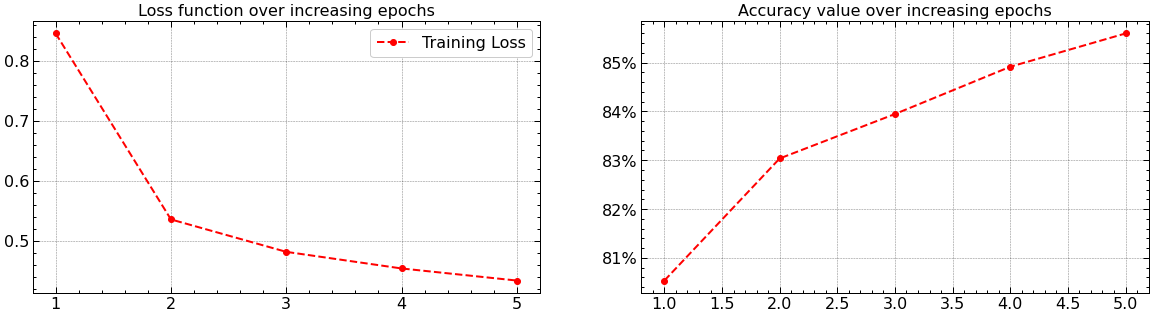

In [10]:
from matplotlib import ticker
import matplotlib.pyplot as plt
# Display variation of training loss and accuracy over increasing epochs
plt.style.use(['science', 'notebook', 'grid'])
epochs = np.arange(total_epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Loss function over increasing epochs")
plt.plot(epochs, losses, "ro--", label="Training Loss")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, "ro--", label="Training accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()